In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import random
import ast

### BUILD CONTENT-BASED SIMILARITY

In [4]:
def calculate_content_similarity():
    subject_cols_aspirants = [col for col in aspirants_processed.columns if col.startswith('Pref_')]
    subject_cols_mentors = [col for col in mentors_processed.columns if col.startswith('Spec_')]
    aspirant_subject_matrix = aspirants_processed[subject_cols_aspirants].values
    mentor_subject_matrix = mentors_processed[[f"Spec_{col[5:]}" for col in subject_cols_aspirants]].values
    subject_similarity = np.zeros((len(aspirants_processed), len(mentors_processed)))
    
    for i in range(len(aspirants_processed)):
        for j in range(len(mentors_processed)):
            subject_similarity[i, j] = np.dot(aspirant_subject_matrix[i], mentor_subject_matrix[j])
    
    subject_similarity = subject_similarity / (np.sum(aspirant_subject_matrix, axis=1)[:, np.newaxis] + 1e-8)
    learning_style_cols = [col for col in aspirants_processed.columns if col.startswith('Learning_')]
    teaching_style_cols = [col for col in mentors_processed.columns if col.startswith('Teaching_')]
    learning_teaching_compatibility = {
        'Learning_Visual': {'Teaching_Interactive': 0.8, 'Teaching_Problem-solving': 0.6, 'Teaching_Lecture-based': 0.4},
        'Learning_Auditory': {'Teaching_Lecture-based': 0.9, 'Teaching_Interactive': 0.7, 'Teaching_Problem-solving': 0.5},
        'Learning_Kinesthetic': {'Teaching_Problem-solving': 0.9, 'Teaching_Interactive': 0.7, 'Teaching_Lecture-based': 0.3},
        'Learning_Reading/Writing': {'Teaching_Problem-solving': 0.8, 'Teaching_Lecture-based': 0.7, 'Teaching_Interactive': 0.6}
    }
    style_compatibility = np.zeros((len(aspirants_processed), len(mentors_processed)))
    
    for i, aspirant_idx in enumerate(aspirants_processed.index):
        aspirant_style = None
        for style_col in learning_style_cols:
            if aspirants_processed.loc[aspirant_idx, style_col] == 1:
                aspirant_style = style_col
                break
        
        if aspirant_style:
            for j, mentor_idx in enumerate(mentors_processed.index):
                mentor_style = None
                for style_col in teaching_style_cols:
                    if mentors_processed.loc[mentor_idx, style_col] == 1:
                        mentor_style = style_col
                        break
                
                if mentor_style and aspirant_style in learning_teaching_compatibility:
                    style_compatibility[i, j] = learning_teaching_compatibility[aspirant_style].get(mentor_style, 0.2)
                else:
                    style_compatibility[i, j] = 0.2
    
    content_similarity = 0.7 * subject_similarity + 0.3 * style_compatibility
    return content_similarity

content_similarity = calculate_content_similarity()

print("\nContent Similarity Matrix Shape (Aspirants × Mentors):", content_similarity.shape)
print("Sample similarity scores for first aspirant:")
print(content_similarity[0, :5])



Content Similarity Matrix Shape (Aspirants × Mentors): (100, 50)
Sample similarity scores for first aspirant:
[0.59 0.18 0.18 0.12 0.18]


In [3]:
aspirants_processed = pd.read_csv('aspirants_processed.csv')
mentors_processed = pd.read_csv('mentors_processed.csv')

### PROCESSING INTERACTION DATA FOR COLLABORATIVE FILTERING

In [7]:
def process_interaction_data():
    ratings_df = interactions_df[interactions_df['Rating'].notna()].copy()
    ratings_df['Rating'] = ratings_df['Rating'].astype(float)
    interaction_type_dummies = pd.get_dummies(interactions_df['Interaction Type'], prefix='Int')
    interaction_features = pd.concat([interactions_df[['Aspirant ID', 'Mentor ID']], interaction_type_dummies], axis=1)
    interaction_agg = interaction_features.groupby(['Aspirant ID', 'Mentor ID']).sum().reset_index()
    interaction_matrix = np.zeros((len(aspirants_processed), len(mentors_processed)))
    
    for idx, row in interaction_agg.iterrows():
        aspirant_idx = aspirants_processed.index[aspirants_processed['Aspirant ID'] == row['Aspirant ID']].tolist()
        mentor_idx = mentors_processed.index[mentors_processed['Mentor ID'] == row['Mentor ID']].tolist()
        if aspirant_idx and mentor_idx:
            interaction_matrix[aspirant_idx[0], mentor_idx[0]] = (
                row.get('Int_Message', 0) * 0.3 + 
                row.get('Int_Session', 0) * 0.5 + 
                row.get('Int_Rating', 0) * 0.2
            )
    
    ratings_matrix = np.zeros((len(aspirants_processed), len(mentors_processed)))
    ratings_matrix.fill(np.nan)
    
    for idx, row in ratings_df.iterrows():
        aspirant_idx = aspirants_processed.index[aspirants_processed['Aspirant ID'] == row['Aspirant ID']].tolist()
        mentor_idx = mentors_processed.index[mentors_processed['Mentor ID'] == row['Mentor ID']].tolist()
        if aspirant_idx and mentor_idx:
            ratings_matrix[aspirant_idx[0], mentor_idx[0]] = row['Rating']
    
    train_data = []
    for i in range(ratings_matrix.shape[0]):
        for j in range(ratings_matrix.shape[1]):
            if not np.isnan(ratings_matrix[i, j]):
                train_data.append((i, j, ratings_matrix[i, j]))
    
    return interaction_matrix, ratings_matrix, train_data

interaction_matrix, ratings_matrix, train_data = process_interaction_data()

print("\nInteraction Matrix Shape:", interaction_matrix.shape)
print("Ratings Matrix Shape:", ratings_matrix.shape)
print(f"Number of rating data points: {len(train_data)}")



Interaction Matrix Shape: (100, 50)
Ratings Matrix Shape: (100, 50)
Number of rating data points: 71


In [6]:
interactions_df = pd.read_csv('interactions.csv')

### BUILDING AND TRAINING HYBRID RECOMMENDATION MODEL

In [12]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7089 - mean_absolute_error: 0.3222 - val_loss: 0.7027 - val_mean_absolute_error: 0.3364
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6597 - mean_absolute_error: 0.3110 - val_loss: 0.6617 - val_mean_absolute_error: 0.3362
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6179 - mean_absolute_error: 0.3064 - val_loss: 0.6244 - val_mean_absolute_error: 0.3361
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5757 - mean_absolute_error: 0.2908 - val_loss: 0.5902 - val_mean_absolute_error: 0.3362
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5406 - mean_absolute_error: 0.3043 - val_loss: 0.5590 - val_mean_absolute_error: 0.3360
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4938 - mean_absolute_error: 0.2700 - val_loss: 0.5301 - val_mean_absolute_error: 0.3355
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4817 - mean_absolute_error: 0.2880 - val_loss: 0.5035 - val_mean_


Model saved as 'mentor_recommender.h5'


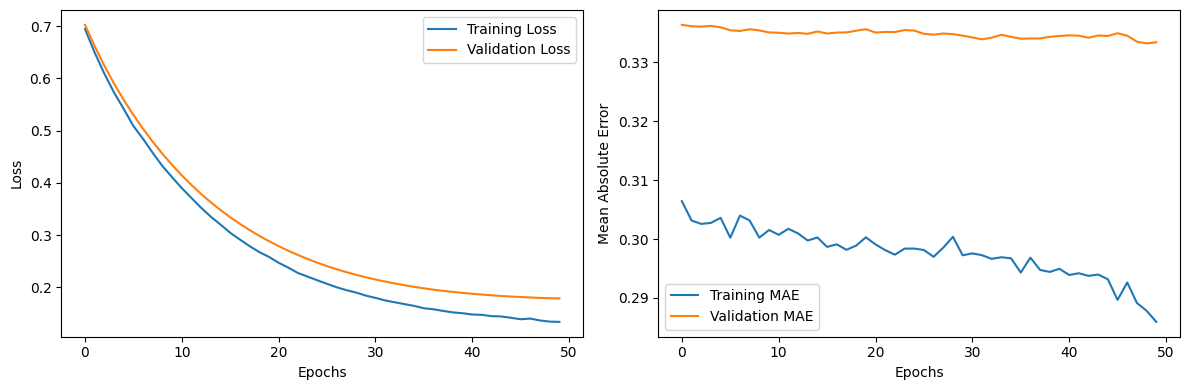

In [13]:
def build_hybrid_model():
    n_aspirants = len(aspirants_processed)
    n_mentors = len(mentors_processed)
    embedding_dim = 20

    aspirant_indices = np.array([x[0] for x in train_data])
    mentor_indices = np.array([x[1] for x in train_data])
    ratings = np.array([x[2] for x in train_data])
    ratings_normalized = (ratings - 1) / 4.0

    aspirant_input = Input(shape=(1,), name='aspirant_input')
    aspirant_embedding = Embedding(n_aspirants, embedding_dim, name='aspirant_embedding',
                                    embeddings_regularizer=l2(0.01))(aspirant_input)
    aspirant_vec = Flatten()(aspirant_embedding)

    mentor_input = Input(shape=(1,), name='mentor_input')
    mentor_embedding = Embedding(n_mentors, embedding_dim, name='mentor_embedding',
                                  embeddings_regularizer=l2(0.01))(mentor_input)
    mentor_vec = Flatten()(mentor_embedding)

    content_sim_input = Input(shape=(1,), name='content_similarity')
    concat_features = Concatenate()([aspirant_vec, mentor_vec, content_sim_input])

    dense1 = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(concat_features)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    output = Dense(1, activation='sigmoid', name='output')(dropout2)

    model = keras.Model(inputs=[aspirant_input, mentor_input, content_sim_input], outputs=output)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error', metrics=['mean_absolute_error'])

    content_sim_values = np.array([content_similarity[a_idx, m_idx] for a_idx, m_idx, _ in train_data])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit([aspirant_indices, mentor_indices, content_sim_values],
                        ratings_normalized, epochs=50, batch_size=8,
                        validation_split=0.2, callbacks=[early_stopping], verbose=1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_absolute_error'], label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')

    return model, history

model, history = build_hybrid_model()
model.save("mentor_recommender.h5")
print("\nModel saved as 'mentor_recommender.h5'")


### GENERATING RECOMMENDATIONS

In [20]:
mentor_df = pd.read_csv('mentors.csv')
interactions_df = pd.read_csv('interactions.csv')

def recommend_mentors(aspirant_id, top_n=3):
    aspirant_idx = aspirants_processed.index[aspirants_processed['Aspirant ID'] == aspirant_id].tolist()[0]
    aspirant_indices = np.full(len(mentors_processed), aspirant_idx)
    mentor_indices = np.arange(len(mentors_processed))
    content_sim_values = content_similarity[aspirant_idx, :]
    predictions = model.predict([aspirant_indices, mentor_indices, content_sim_values])
    predictions_scaled = predictions * 4.0 + 1.0
    mentor_scores = pd.DataFrame({
        'Mentor ID': mentor_df['Mentor ID'],
        'Predicted Score': predictions_scaled.flatten(),
        'Content Similarity': content_similarity[aspirant_idx, :]
    })
    existing_interactions = interactions_df[interactions_df['Aspirant ID'] == aspirant_id]['Mentor ID'].unique()
    mentor_scores['Has Interaction'] = mentor_scores['Mentor ID'].isin(existing_interactions)
    recommended_mentors = mentor_scores.sort_values('Predicted Score', ascending=False).head(top_n)
    recommendations_with_details = recommended_mentors.merge(
        mentor_df[['Mentor ID', 'Specialization', 'College Attended', 'Teaching Style', 'Rating']],
        on='Mentor ID'
    )
    return recommendations_with_details

sample_aspirant_id = 3
recommendations = recommend_mentors(sample_aspirant_id)
print(f"\nTop 3 Recommended Mentors for Aspirant {sample_aspirant_id}:")
print(recommendations[['Mentor ID', 'Specialization', 'College Attended', 'Predicted Score', 'Content Similarity', 'Has Interaction']])


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Top 3 Recommended Mentors for Aspirant 3:
   Mentor ID       Specialization  College Attended  Predicted Score  \
0        116  ['Legal Reasoning']       NLIU Bhopal         3.056372   
1        106  ['Legal Reasoning']  GNLU Gandhinagar         3.051637   
2        133  ['Legal Reasoning']   NLSIU Bangalore         3.049967   

   Content Similarity  Has Interaction  
0                0.18             True  
1                0.24            False  
2                0.24            False  


In [17]:
mentor_df = pd.read_csv('mentors.csv')
interactions_df = pd.read_csv('interactions.csv')

### MODEL EXPLAINABILITY WITH SHAP

In [24]:
import shap

def explain_recommendation(aspirant_id, mentor_id):
    aspirant_idx = aspirants_processed.index[aspirants_processed['Aspirant ID'] == aspirant_id].tolist()[0]
    mentor_idx = mentors_processed.index[mentors_processed['Mentor ID'] == mentor_id].tolist()[0]
    content_sim = content_similarity[aspirant_idx, mentor_idx]
    
    if len(train_data) > 100:
        background_samples = random.sample(train_data, 100)
    else:
        background_samples = train_data
    
    background_aspirants = np.array([x[0] for x in background_samples])
    background_mentors = np.array([x[1] for x in background_samples])
    background_content = np.array([content_similarity[a, m] for a, m, _ in background_samples])
    
    explainer = shap.KernelExplainer(
        model=lambda x: model.predict([x[:, 0], x[:, 1], x[:, 2]]).flatten(),
        data=np.column_stack([background_aspirants, background_mentors, background_content])
    )
    
    test_instance = np.array([[aspirant_idx, mentor_idx, content_sim]])
    shap_values = explainer.shap_values(test_instance)
    
    aspirant_details = aspirants_processed[aspirants_processed['Aspirant ID'] == aspirant_id]
    mentor_details = mentor_df[mentor_df['Mentor ID'] == mentor_id]
    
    explanation = {
        'Aspirant': {
            'ID': aspirant_id,
            'Preferred Subjects': aspirant_details['Essay/Personal Statement'].values[0],
            'Learning Style': aspirant_details[['Learning_Auditory', 'Learning_Kinesthetic', 'Learning_Reading/Writing', 'Learning_Visual']].idxmax(axis=1).values[0],
            'Preparation Level': aspirant_details['Prep_Level_Encoded'].values[0]
        },
        'Mentor': {
            'ID': mentor_id,
            'Specialization': mentor_details['Specialization'].values[0],
            'Teaching Style': mentor_details['Teaching Style'].values[0],
            'Years of Experience': mentor_details['Years of Experience'].values[0],
            'Rating': mentor_details['Rating'].values[0]
        },
        'Recommendation': {
            'Content Similarity': content_sim,
            'SHAP Base Value': explainer.expected_value,
            'SHAP Values': {
                'Aspirant': shap_values[0][0],
                'Mentor': shap_values[0][1],
                'Content Similarity': shap_values[0][2]
            }
        }
    }
    
    return explanation

top_mentor_id = recommendations.iloc[0]['Mentor ID']
explanation = explain_recommendation(sample_aspirant_id, top_mentor_id)

print("\nExplanation for recommendation:")
print(f"Aspirant {sample_aspirant_id} with preferred subjects {explanation['Aspirant']['Preferred Subjects']} and {explanation['Aspirant']['Learning Style']} learning style")
print(f"is matched with Mentor {top_mentor_id} who specializes in {explanation['Mentor']['Specialization']} with a {explanation['Mentor']['Teaching Style']} teaching style")
print(f"Content similarity: {explanation['Recommendation']['Content Similarity']:.2f}")
print("SHAP Values contribution to recommendation:")
for factor, value in explanation['Recommendation']['SHAP Values'].items():
    print(f"  - {factor}: {value:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Explanation for recommendation:
Aspirant 3 with preferred subjects Looking to improve my English Comprehension skills and Learning_Visual learning style
is matched with Mentor 116 who specializes in ['Legal Reasoning'] with a Problem-solving teaching style
Content similarity: 0.18
SHAP Values contribution to recommendation:
  - Aspirant: -0.0107
  - Mentor: 0.0064
  - Content Similarity: 0.0025


### TESTING THE RELOADED MODEL

In [29]:
mentors_df = pd.read_csv('mentors.csv')
interactions_df = pd.read_csv('interactions.csv')

def test_reloaded_model():
    reloaded_model = keras.models.load_model("mentor_recommender.h5")
    test_aspirant_id = 15
    aspirant_idx = aspirants_processed.index[aspirants_processed['Aspirant ID'] == test_aspirant_id].tolist()[0]
    aspirant_indices = np.full(len(mentors_processed), aspirant_idx)
    mentor_indices = np.arange(len(mentors_processed))
    content_sim_values = content_similarity[aspirant_idx, :]
    original_predictions = model.predict([aspirant_indices, mentor_indices, content_sim_values])
    reloaded_predictions = reloaded_model.predict([aspirant_indices, mentor_indices, content_sim_values])
    is_equal = np.allclose(original_predictions, reloaded_predictions, atol=1e-6)
    print("\nTesting reloaded model...")
    print(f"Original and reloaded model predictions are the same: {is_equal}")
    top_indices = np.argsort(reloaded_predictions.flatten())[-3:][::-1]
    top_mentor_ids = mentors_df.iloc[top_indices]['Mentor ID'].values
    print(f"Top 3 mentors for Aspirant {test_aspirant_id} using reloaded model: {top_mentor_ids}")
    return is_equal

model_reload_successful = test_reloaded_model()

print("\n=== SUMMARY ===")
print(f"Model training completed successfully.")
print(f"Model saved to disk and reload test {'passed' if model_reload_successful else 'failed'}.")
print(f"The system can recommend top mentors for any aspirant based on their profile and historical interactions.")
print("For each recommendation, SHAP explanations can be generated to understand why a mentor was recommended.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Testing reloaded model...
Original and reloaded model predictions are the same: True
Top 3 mentors for Aspirant 15 using reloaded model: [137 116 130]

=== SUMMARY ===
Model training completed successfully.
Model saved to disk and reload test passed.
The system can recommend top mentors for any aspirant based on their profile and historical interactions.
For each recommendation, SHAP explanations can be generated to understand why a mentor was recommended.
